## Importing libraries and Downloading data



In [ ]:
# Importing libraries

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Installing fastai to download the dataset
! pip install -U fastai

In [ ]:
# Downloading the dataset

from fastai.data.external import untar_data, URLs
path = untar_data(URLs.COCO_SAMPLE)
path = str(path) + "/train_sample"      # Modifying the path
print("Path of dataset is", path)       # Prints the path to the dataset

Path of dataset is /root/.fastai/data/coco_sample/train_sample


In [ ]:
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names

np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # Choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)  # Generating index to fetch images

train_idxs = rand_idxs[:8000] # Selecting the first 8000 as training set
val_idxs = rand_idxs[8000:] # Selecting last 2000 as validation set

train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

print(len(train_paths), len(val_paths))

8000 2000


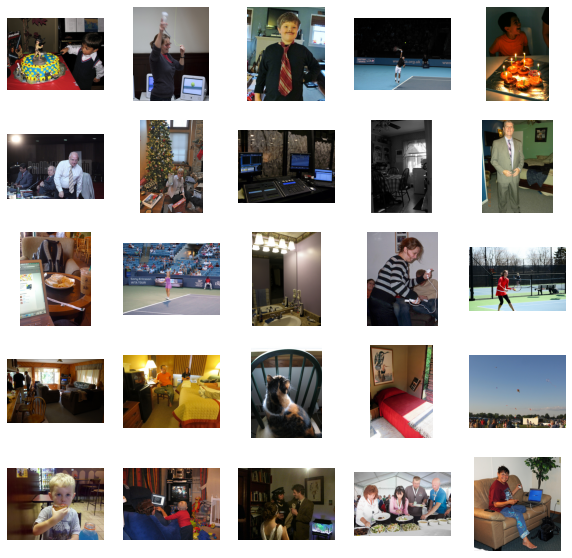

In [ ]:
# Printing a few examples from the dataset

_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

## Making Dataset and Dataloaders

In [ ]:
# Dataset Class

class ColorizationDataset(Dataset):
    def __init__ (self,paths,split):
        self.paths = paths
        self.transforms = transforms
        self.split = split
        if(self.split == "train"):
          self.transforms = transforms.Compose([
                transforms.Resize((256, 256),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),      # Apppling data augmentation
            ])                                          
          
        else:
          self.transforms = transforms.Resize((256, 256),  Image.BICUBIC)
    
    def __len__ (self):
        return len(self.paths)

    def __getitem__ (self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img_lab = rgb2lab(img).astype("float32")    # Converting RGB to LAB colorspace
        img_lab = transforms.ToTensor()(img_lab)    
        L = img_lab[[0], ...] / 50. - 1.            # Normalizing values between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. 
        return {'L' : L, 'ab' : ab}

In [ ]:
train_dataset = ColorizationDataset(train_paths,split = "train")
val_dataset = ColorizationDataset(val_paths,split = "val")

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
# Making Dataloader
def CreateDataloader(dataset, batchsize, num_workers):
    dataloader = DataLoader(dataset, batch_size=batchsize, num_workers=num_workers, pin_memory=True, shuffle=True)
    return dataloader

In [ ]:
train_dl = CreateDataloader(train_dataset, 16, 4)
val_dl = CreateDataloader(val_dataset, 16, 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##  Generator Model

The generator comprises of a U-net architecture which downsamples and then upsamples the image.

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, inplace = True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# Printing the Generator Model
gen_model = Unet()
print(gen_model)

Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [ ]:
# Printing Generator Model Summary
from torchsummary import summary
summary(gen_model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,024
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

## Discriminator Model

The architecture of our discriminator comprises of blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. We implement a Patch GAN disriminator which penalizes images on patches of pixels.

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] 
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]         
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# Seeing the Discriminator network
discriminator_model = PatchDiscriminator(3)
discriminator_model

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
# Printing summary
from torchsummary import summary
summary(discriminator_model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,765,633
Trainable params: 2,765,633
Non-trainable params: 0
---------------------------

## GAN Loss

Creating a class for losses in our network.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()  
        
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))

    def get_labels(self, preds, target_is_real): # Returns 1 if target is real else 0
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)    # Returning labels in the size of predictions
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Weights and Bias initialization

In [ ]:
def init_weights(net, gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)  # Initializing weights from normal distribution with mean : 0 ans std : 0.02
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)             # Initializing the biases as zeroes

        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## Main Model Class      

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G = None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):   # Passing the hyperparameters as arguments to the main class
        super().__init__()
        
        self.lambda_L1 = lambda_L1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if net_G is None:                               # Initializing generator and discriminator model
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
            
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss().to(self.device)                  # Losses  
        self.L1criterion = nn.L1Loss()

        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))  # Optimizers for generator and discriminator networks
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):   # Function to set requires_grad of parameters
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):     # Function to send input and output tensors to CUDA
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):   # Backpropogation in Discriminator
        fake_image = torch.cat([self.L, self.fake_color], dim=1)    
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):   # Backpropogation in Generator
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):     # Optimizer function
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False) # Keeping the discriminator model constant during generator training
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step() 

## Utility Functions

Defining functions to plot results, update losses, create loss meters, etc.

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3   # Initializing to zero
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count  # Calculates average over batches of data

# Initializes different loss meters and returns a dict of loss names and values
def create_loss_meters():  
    loss_D = AverageMeter()
    loss_D_fake = AverageMeter()
    loss_D_real= AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D': loss_D,
            'loss_D_fake' : loss_D_fake,
            'loss_D_real' : loss_D_real,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

# Converting from lab to rgb colorspace
def lab_to_rgb(L, ab): 
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

# Function to plot pictures generated by the network  
def visualize(model, data, epoch):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    
    fig.savefig(f"Image_Colorization_{epoch}.png")

# Printing loss values       
def log_results(loss_meter_dict):
    for loss_name, loss_value in loss_meter_dict.items():
        print(f"{loss_name}: {loss_value.avg:.5f}")

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Training

In [ ]:
# Making list of all losses
loss_D_list = []
loss_D_real_list = []
loss_D_fake_list = []
loss_G_GAN_list = []
loss_G_L1_list = []
loss_G_list = []

epochs = 50
def train_model(model, train_dl, epochs):
    valid_data = next(iter(val_dl))        # Getting a batch of data for visualizing results

    for e in range(epochs):
  
        loss_meter_dict = create_loss_meters() 
                                         
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))        # Updating the loss_meter_dict
        
        model_save_name = f"gan_model_final_{e+1}.pt"
        path = f"/content/gdrive/My Drive/{model_save_name}"      # Saving the model after every epoch
        torch.save(model.state_dict(), path)

        # Appending losses 
        loss_D_list.append(loss_meter_dict["loss_D"])
        loss_D_fake_list.append(loss_meter_dict["loss_D_fake"])
        loss_D_real_list.append(loss_meter_dict["loss_D_real"])
        loss_G_GAN_list.append(loss_meter_dict["loss_G_GAN"])
        loss_G_L1_list.append(loss_meter_dict["loss_G_L1"])
        loss_G_list.append(loss_meter_dict["loss_G"])

        print(f"\nEpoch {e+1}/{epochs}")
        log_results(loss_meter_dict) # Function to print out the losses
        visualize(model, valid_data, e) # Function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, epochs)

## Plotting Losses

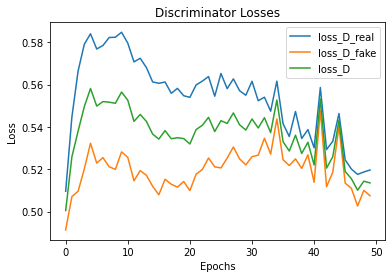

In [ ]:
t = []
epochs = 50
for i in range(epochs):
    t.append(i)

plt.plot(t,loss_D_real_list, label = "loss_D_real")
plt.plot(t,loss_D_fake_list, label = "loss_D_fake")
plt.plot(t,loss_D_list, label = "loss_D")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Losses")

plt.legend()
plt.show()

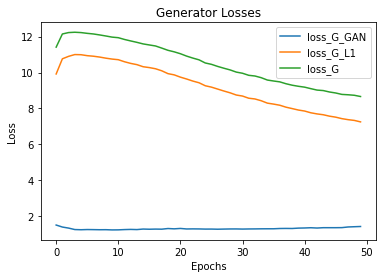

In [ ]:
plt.plot(t,loss_G_GAN_list, label = "loss_G_GAN")
plt.plot(t,loss_G_L1_list, label = "loss_G_L1")
plt.plot(t,loss_G_list, label = "loss_G")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Losses")

plt.legend()
plt.show()

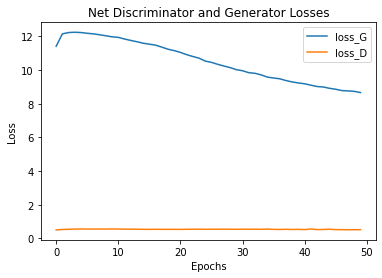

In [ ]:
plt.plot(t,loss_G_list, label = "loss_G")
plt.plot(t,loss_D_list, label = "loss_D")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Net Discriminator and Generator Losses")

plt.legend()
plt.show()

## Using Pretraining


We will use  a pretrained ResNet18 as the backbone of the U-Net. Also, we are going to train the U-Net on our training set with only L1 Loss. Then we will move to the combined adversarial and L1 loss, as we did earlier.

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
# Creating generator network with ResNet18 as backbone
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)   # Removing the last two layers (GlobalAveragePooling and a Linear layer)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)          
    return net_G

### Pretraining the generator

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
        
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20) 
torch.save(net_G.state_dict(), "res18-unet.pt")              # Saving the pretrained model

### Final Training

In [ ]:
def train_model(model, train_dl, epochs):
    valid_data = next(iter(val_dl))        # Getting a batch of data for visualizing results

    for e in range(epochs):
  
        loss_meter_dict = create_loss_meters() 
                                         
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))        # Updating the loss_meter_dict
        
        model_save_name = f"gan_model_final_{e+1}.pt"
        path = f"/content/gdrive/My Drive/{model_save_name}"      # Saving the model after every epoch
        torch.save(model.state_dict(), path)


        print(f"\nEpoch {e+1}/{epochs}")
        log_results(loss_meter_dict) # Function to print out the losses
        visualize(model, valid_data, e) # Function displaying the model's outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)